# Library

In [1]:
import os
seed = 0
os.environ['PYTHONHASHSEED']=str(seed)


In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [3]:
import pandas as pd
import numpy as np
import cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import  StandardScaler
# import sys
# !{sys.executable} -m pip install torchvision

import tensorflow as tf

# tf.enable_eager_execution()
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.enable_eager_execution()
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten , Input ,BatchNormalization, Concatenate, Layer , Maximum , Softmax
from tensorflow.keras.layers import  GlobalAveragePooling2D, AveragePooling2D , Conv1D , MaxPooling1D, Average, Dropout, LayerNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,balanced_accuracy_score
import joblib

# from keras.applications import vgg16
# from keras.applications.efficientnet import EfficientNetB3 


from tensorflow.keras.applications import ResNet50, EfficientNetB2, MobileNetV3Large

In [4]:
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

# import pytorch_tabnet
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch

In [5]:
tf.__version__

'2.8.0'

# Function 

In [6]:
def take_f1_Score(y_test, y_pred) :
  k = list(f1_score(y_test, y_pred, average=None))
  ds = []
  for i in range(len(k)):
    kk = round(k[i]*100, 2)
    ds.append(kk)
  print(ds)

In [7]:
def model_1concat_gating(shape1, shape2 , all_list_filters, list_num_experts, same_seed = True):
    
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
        # K.set_session(sess)
        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
        gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    
    assert len(all_list_filters) == list_num_experts
    names = '0'
    set_seed(0)
    #------------------------------------------
    input = Input(shape = (shape1, shape2, 1))
    output = Mixture_of_Experts(input, all_list_filters , list_num_experts,names)
    #------------------------------------------
#     concat = Concatenate(axis=1)([MoE_1, MoE_2, MoE_3])
#     concat = Dense(units = 600,
#                    activation = tf.nn.relu)(MoE_1)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     concat = Dense(units = 1000 ,
#                    activation = tf.nn.relu)(concat)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     softmax = Dense(12, activation = tf.nn.softmax )(concat)



    
    model = Model(inputs=[input], outputs=output)
    return model


In [8]:
def model_2concat_gating(shape1, shape2 , all_list_filters_0, all_list_filters_1, list_num_experts_0, list_num_experts_1, 
                         same_seed = [True,True], method = 'concat'):
    
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names, same_seed) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
#         gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    
    assert (len(all_list_filters_0) + len(all_list_filters_1)) == list_num_experts_0 + list_num_experts_1
    assert len(all_list_filters_0) == list_num_experts_0
    assert len(all_list_filters_1) == list_num_experts_1
    names = ['1','2']
    set_seed(0)
    #------------------------------------------
    input1 = Input(shape = (shape1, shape2, 1))
    MoE_1 = Mixture_of_Experts(input1, all_list_filters_0 , list_num_experts_0,names[0],same_seed[0])
    input2 = Input(shape = (shape1, shape2, 1))
    MoE_2 = Mixture_of_Experts(input2, all_list_filters_1 , list_num_experts_1,names[1],same_seed[1])
    #------------------------------------------
    if method == 'concat':
        concat = Concatenate(axis=1)([MoE_1, MoE_2])
        concat = Dense(units = 600,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        concat = Dense(units = 1000 ,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        softmax = Dense(12, activation = tf.nn.softmax )(concat)
    elif method == 'max':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        maxs = Maximum()([MoE_1,MoE_2])
        softmax = Softmax()(maxs)
    elif method == 'average':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        average = Average()([MoE_1,MoE_2])
        softmax = Softmax()(average)
    else :
        print('Wrong method')
        return False
    #------------------------------------------
    model = Model(inputs=[input1,input2], outputs=softmax)
    return model

In [9]:
def draw_cm (y_true,y_pred):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true, y_pred,normalize = 'true')
  ds = []
  for i in range(len(cm)):
    kk = round(cm[i][i], 4)
    ds.append(kk)
  cm_df = pd.DataFrame(cm,
                      index = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ], 
                      columns = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ])


  import seaborn as sns
  sns.color_palette("tab10")
  #Plotting the confusion matrix
  plt.figure(figsize=(10,10))
  sns.heatmap(cm_df, annot=True,fmt='.2%', cmap='gist_stern_r')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
# plt.savefig('confusion.png')
  return ds


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
SUB = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/sensor.csv', skiprows = 1)
SUB.head()

,Time,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).1,Y-axis Accelerometer (g).1,...,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Raw Brainwave Signal,Infrared 1,Infrared 2,Infrared 3,Infrared 4,Infrared 5,Infrared 6,Label
0,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,-0.981,0.260,...,315.915,2108.154,45.0,1,1,1,1,1,1,7
1,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,-0.981,0.260,...,344.146,2108.154,1.0,1,1,1,1,1,1,7
2,2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,-0.975,0.282,...,372.012,2108.154,325.0,1,1,1,1,1,1,7
3,2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,-0.973,0.301,...,356.463,2108.154,396.0,1,1,1,1,1,1,7
4,2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,-0.973,0.301,...,126.768,2108.154,-436.0,1,1,1,1,1,1,7


In [13]:
print(SUB.shape)

(294678, 44)


# Data Processing

In [14]:
SUB.isnull().sum()

Time                              0
X-axis Accelerometer (g)          0
Y-axis Accelerometer (g)          0
Z-axis Accelerometer (g)          0
Roll Gyroscrope (deg/s)           0
Pitch Gyroscope (deg/s)           0
Yaw Gyroscope (deg/s)             0
Luminosity (lux)                  0
X-axis Accelerometer (g).1    36109
Y-axis Accelerometer (g).1    36109
Z-axis Accelerometer (g).1    36109
Roll Gyroscrope (deg/s).1     36109
Pitch Gyroscope (deg/s).1     36109
Yaw Gyroscope (deg/s).1       36109
Luminosity (lux).1            36109
X-axis Accelerometer (g).2        0
Y-axis Accelerometer (g).2        0
Z-axis Accelerometer (g).2        0
Roll Gyroscrope (deg/s).2         0
Pitch Gyroscope (deg/s).2         0
Yaw Gyroscope (deg/s).2           0
Luminosity (lux).2                0
X-axis Accelerometer (g).3        0
Y-axis Accelerometer (g).3        0
Z-axis Accelerometer (g).3        0
Roll Gyroscrope (deg/s).3         0
Pitch Gyroscope (deg/s).3         0
Yaw Gyroscope (deg/s).3     

In [15]:
NA_cols  = SUB.columns[SUB.isnull().any()]
print('Columns contain NULL values : \n', NA_cols )


SUB.dropna(inplace = True)
SUB.drop_duplicates(inplace = True)
print('Sensor Data shape after dropping NaN and redudant samples :',SUB.shape)


times = SUB['Time']

list_DROP = [ 'Infrared 1', 
              'Infrared 2', 
              'Infrared 3', 
              'Infrared 4', 
              'Infrared 5', 
              'Infrared 6']
SUB.drop(list_DROP, axis = 1, inplace=  True )
SUB.drop( NA_cols, axis = 1, inplace=  True ) # drop NAN COLS

print('Sensor Data shape after dropping columns contain NaN values :',SUB.shape)

Columns contain NULL values : 
 Index(['X-axis Accelerometer (g).1', 'Y-axis Accelerometer (g).1',
       'Z-axis Accelerometer (g).1', 'Roll Gyroscrope (deg/s).1',
       'Pitch Gyroscope (deg/s).1', 'Yaw Gyroscope (deg/s).1',
       'Luminosity (lux).1', 'Raw Brainwave Signal '],
      dtype='object')
Sensor Data shape after dropping NaN and redudant samples : (258114, 44)
Sensor Data shape after dropping columns contain NaN values : (258114, 30)


In [16]:
SUB.set_index('Time', inplace = True)
SUB.head()

,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).2,Y-axis Accelerometer (g).2,Z-axis Accelerometer (g).2,...,Yaw Gyroscope (deg/s).3,Luminosity (lux).3,X-axis Accelerometer (g).4,Y-axis Accelerometer (g).4,Z-axis Accelerometer (g).4,Roll Gyroscrope (deg/s).4,Pitch Gyroscope (deg/s).4,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Label
Time,,,,,,,,,,,,,,,,,,,,,
2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,0.146,0.895,0.367,...,9.207,1231.336,-1.240,-0.557,0.227,-75.854,44.024,315.915,2108.154,7
2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,0.146,0.895,0.367,...,5.122,1231.336,-1.240,-0.557,0.227,-28.780,55.549,344.146,2108.154,7
2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,0.178,0.896,0.373,...,4.329,1231.336,-1.884,-0.687,0.251,27.256,87.134,372.012,2108.154,7
2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,0.160,0.895,0.372,...,0.366,1231.336,-1.884,-0.687,0.251,2.866,117.683,356.463,2108.154,7
2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,0.160,0.895,0.372,...,-3.232,1231.336,-1.597,-0.646,0.112,10.000,30.671,126.768,2108.154,7


In [19]:
cam = '1'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/image_1.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/name_1.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/label_1.npy'

img_1 = np.load(image)
label_1 = np.load(label)
name_1 = np.load(name)

cam = '2'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/image_2.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/name_2.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/label_2.npy'

img_2 = np.load(image)
label_2 = np.load(label)
name_2 = np.load(name)



In [20]:
print(len(img_1))
print(len(name_1))
print(len(img_2))
print(len(name_2))

294677
294677
294677
294677


In [21]:
# remove NaN values corresponding to index sample in csv file
redundant_1 = list(set(name_1) - set(times))
redundant_2 = list(set(name_2) - set(times))
ind = np.arange(0,294677)


red_in1 = ind[np.isin(name_1,redundant_1)]
name_1 =  np.delete(name_1, red_in1)
img_1 = np.delete(img_1, red_in1, axis = 0 )
label_1 = np.delete(label_1, red_in1)

red_in2 = ind[np.isin(name_2,redundant_2)]
name_2 =  np.delete(name_2, red_in2)
img_2 = np.delete(img_2, red_in2, axis = 0 )
label_2 = np.delete(label_2, red_in2)

In [22]:
print(len(name_2))
print(len(name_1))

258113
258113


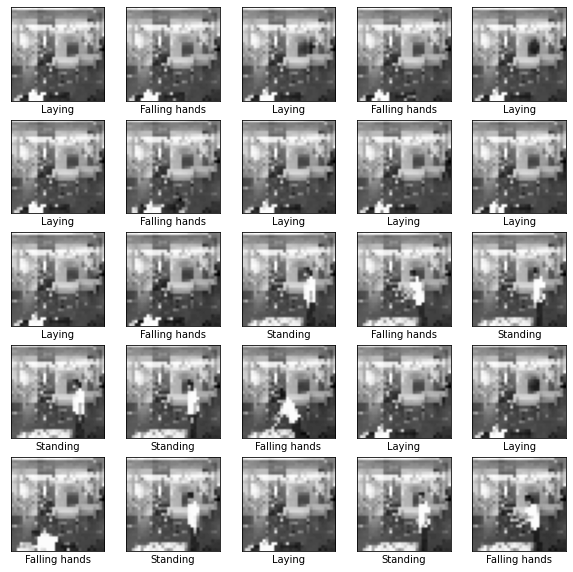

In [23]:
class_name = [    '?????' ,
                'Falling hands' ,
                 'Falling knees' ,
                 'Falling backwards',
                 'Falling sideward' ,
                ' Falling chair',
                ' Walking',
                 'Standing' ,
                 'Sitting' ,
                 'Picking object' ,
                 'Jumping' ,
                 'Laying' ]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_1[i], cmap = 'gray')
    plt.xlabel(class_name[label_1[i]])
plt.show()

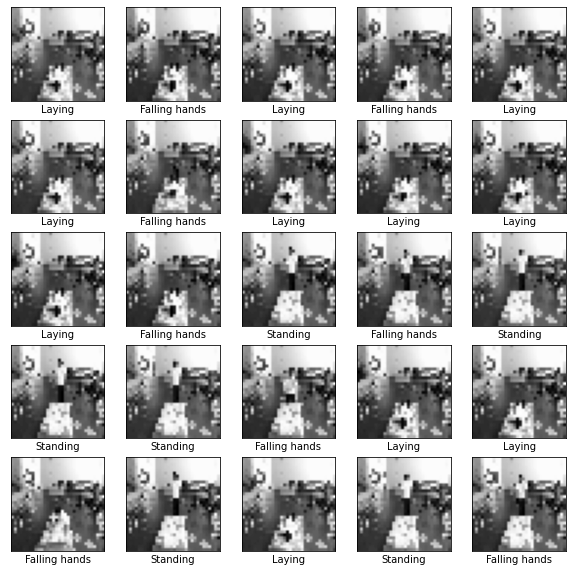

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2[i], cmap = 'gray')
    plt.xlabel(class_name[label_2[i]])
plt.show()

In [25]:

data = SUB.loc[name_1].values
print(img_1.shape)
print(img_2.shape)
print(data.shape)


print((label_2 == data[:,-1]).all())
print((label_1 == data[:,-1]).all())

(258113, 32, 32)
(258113, 32, 32)
(258113, 29)
True
True


In [26]:

# def set_seed(): 
#     SEED = 0 
#     os.environ['PYTHONHASHSEED']=str(SEED)
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
#     rn.seed(SEED)
#     session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     tf.compat.v1.keras.backend.set_session(sess)

# set_seed()
X_csv, y_csv = data[:,:-1] , data[:,-1]

y_csv = np.where(y_csv == 20 , 0, y_csv)
label_1 = np.where(label_1 == 20 , 0, label_1)
label_2 = np.where(label_2 == 20, 0, label_2)
X_train_csv,X_rem_csv,y_train_csv,y_rem_csv = train_test_split(X_csv, y_csv, 
                                                                 train_size = 0.6,
                                                                 random_state = 42)

X_val_csv, X_test_csv, y_val_csv, y_test_csv = train_test_split(X_rem_csv, y_rem_csv, 
                                                                  test_size = 0.5, 
                                                                  random_state = 42)

print('X_train_csv shape : ',X_train_csv.shape)
print('X_test_csv shape : ',X_test_csv.shape)
print('X_val_csv shape : ',X_val_csv.shape)
print('y_train_csv shape : ',y_train_csv.shape)
print('y_test_csv shape : ',y_test_csv.shape)
print('y_val_csv shape : ',y_val_csv.shape)

Y_train_csv = to_categorical(y_train_csv, 12)
Y_test_csv = to_categorical(y_test_csv, 12)
Y_val_csv = to_categorical(y_val_csv, 12)

print('Y_train_csv shape : ',Y_train_csv.shape)
print('Y_test_csv shape : ',Y_test_csv.shape)
print('Y_val_csv shape : ',Y_val_csv.shape)



X_train_1,X_rem_1,y_train_1,y_rem_1 = train_test_split(img_1,label_1,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_1,X_test_1,y_val_1,y_test_1 = train_test_split(X_rem_1,y_rem_1,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )
print('*'*20)
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)


Y_train_1 = to_categorical(y_train_1, 12)
Y_test_1 = to_categorical(y_test_1, 12)
Y_val_1 = to_categorical(y_val_1, 12)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)



X_train_2,X_rem_2,y_train_2,y_rem_2 = train_test_split(img_2,label_2,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_2,X_test_2,y_val_2,y_test_2 = train_test_split(X_rem_2,y_rem_2,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )

print('*'*20)
print('X_train_2 shape : ',X_train_2.shape)
print('X_test_2 shape : ',X_test_2.shape)
print('X_val_2 shape : ',X_val_2.shape)
print('y_train_2 shape : ',y_train_2.shape)
print('y_test_2 shape : ',y_test_2.shape)
print('y_val_2 shape : ',y_val_2.shape)


Y_train_2 = to_categorical(y_train_2, 12)
Y_test_2 = to_categorical(y_test_2, 12)
Y_val_2 = to_categorical(y_val_2, 12)

print('Y_train_2 shape : ',Y_train_2.shape)
print('Y_test_2 shape : ',Y_test_2.shape)
print('Y_val_2 shape : ',Y_val_2.shape)


X_train_csv shape :  (154867, 28)
X_test_csv shape :  (51623, 28)
X_val_csv shape :  (51623, 28)
y_train_csv shape :  (154867,)
y_test_csv shape :  (51623,)
y_val_csv shape :  (51623,)
Y_train_csv shape :  (154867, 12)
Y_test_csv shape :  (51623, 12)
Y_val_csv shape :  (51623, 12)
********************
X_train_1 shape :  (154867, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (154867,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (154867, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)
********************
X_train_2 shape :  (154867, 32, 32)
X_test_2 shape :  (51623, 32, 32)
X_val_2 shape :  (51623, 32, 32)
y_train_2 shape :  (154867,)
y_test_2 shape :  (51623,)
y_val_2 shape :  (51623,)
Y_train_2 shape :  (154867, 12)
Y_test_2 shape :  (51623, 12)
Y_val_2 shape :  (51623, 12)


In [27]:
print((y_train_1 == y_train_csv).all())
print((y_train_2 == y_train_csv).all())

print((y_val_1 == y_val_csv).all())
print((y_val_2 == y_val_csv).all())

print((y_test_1 == y_test_csv).all())
print((y_test_2 == y_test_csv).all())

True
True
True
True
True
True


In [28]:

def display_result(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='weighted'))
    print('Recall score : ', recall_score(y_test , y_pred, average='weighted'))
    print('F1 score : ', f1_score(y_test , y_pred, average='weighted'))
    
def display_result123(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='macro'))
    print('Recall score : ', recall_score(y_test , y_pred, average='macro'))
    print('F1 score : ', f1_score(y_test , y_pred, average='macro'))
    
def scaled_data(X_train, X_test, X_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_test_scaled , X_val_scaled


def convert_to_categorical (y_train, y_test, y_val) :
    print('--------------------------To Categorical ---------------------------')
    Y_train = to_categorical(y_train, 12)
    Y_test = to_categorical(y_test, 12)
    Y_val = to_categorical(y_val,12)
    
    print('Before    : ', y_train[0])
    print('After     : ',Y_train[0])
    return Y_train, Y_test, Y_val 


# X_train_csv_scaled, X_test_csv_scaled , X_val_csv_scaled = scaled_data(X_train_csv, X_test_csv, X_val_csv)
# Y_train_csv , Y_test_csv , Y_val_csv = convert_to_categorical (y_train_csv, y_test_csv, y_val_csv)


In [ ]:
shape1, shape2 = 32,32


path = '/content/drive/MyDrive/Colab Notebooks/Journal/background_train/train_bg_1.npy'
X_au_111 = np.load(path)

path = '/content/drive/MyDrive/Colab Notebooks/Journal/background_train/train_label_bg_1.npy'
y_au_111 = np.load(path)

# ---------------------------------------------------
path = '/content/drive/MyDrive/Colab Notebooks/Journal/background_train/train_bg_2.npy'
X_au_222 = np.load(path)

path = '/content/drive/MyDrive/Colab Notebooks/Journal/background_train/train_label_bg_2.npy'
y_au_222 = np.load(path)

shape1, shape2 = 32,32


y_au_111 = np.where(y_au_111 == 20,0,y_au_111)
y_au_222 = np.where(y_au_222 == 20,0,y_au_222)

In [ ]:
y_au_111 = y_au_111.ravel()
y_au_222 = y_au_222.ravel()

In [ ]:
print(y_au_111.shape, y_au_222.shape)

print(X_au_111.shape,X_au_222.shape)

(5418,) (5418,)
(5418, 32, 32) (5418, 32, 32)


In [ ]:

from scipy import ndimage
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)
    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated



In [ ]:
# 1,2,3,4,5,9

def augmentation(list_class,X_train,y_train):
    def augment_data(given_class,X_train, y_train) :

        fall = (y_train == given_class)
        ind = np.where(fall)[0]
        list_augment = []
        for index in ind:
            image = X_train[index]

            for angle in [30,60,90,120,150] :
#                 rotated = ndimage.rotate(image, angle)
                rotated = rotate(image,angle)
                list_augment.append(rotated)
            # bright increase
            bright = np.ones((32,32) , dtype="uint8") * 60
            brightincrease = cv2.add(image,bright)
            list_augment.append(brightincrease)
            # bright decrease
            bright = np.ones((32,32) , dtype="uint8") * 40
            brightdecrease = cv2.subtract(image,bright)
            list_augment.append(brightdecrease)
            # flip
            flip = cv2.flip(image,3)
            list_augment.append(flip)
            # bilateral
            blur = cv2.bilateralFilter(image,3,80,80)
            list_augment.append(blur)
            label_augment = np.zeros(len(list_augment),dtype  = 'float64')
            label_augment += given_class
        return np.array(list_augment), label_augment 
#     --------------------------------------------------------------
    img_augment = []
    class_augment = []
    for class_label in list_class :
        aug1 , aug2 = augment_data(class_label,X_train,y_train)
        img_augment.append(aug1)
        class_augment.append(aug2)
    
    img_augment = np.concatenate(img_augment,axis = 0)
    class_augment = np.concatenate(class_augment,axis = 0)
    
    return img_augment, class_augment

        
list_class = [1,2,3,4,5,9]
X_au_1,y_au_1 = augmentation(list_class,X_train_1,y_train_1)
X_au_2,y_au_2 = augmentation(list_class,X_train_2,y_train_2)


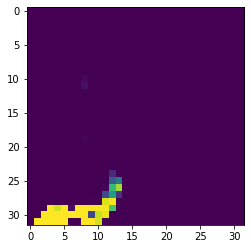

In [ ]:
plt.imshow(X_au_111[0])

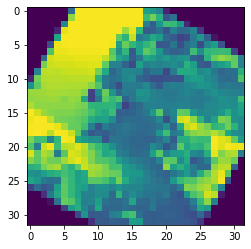

In [ ]:
plt.imshow(X_au_2[10000])

In [ ]:
X_train_1 = np.concatenate((X_train_1,X_au_1,X_au_111),axis = 0 )
print(X_train_1.shape)
X_train_2 = np.concatenate((X_train_2,X_au_2,X_au_222),axis = 0 )
print(X_train_2.shape)



# y_au_1 = np.where(y_au_1 == 20,0,y_au_1)
# y_au_2 = np.where(y_au_2 == 20,0,y_au_2)
# y_au_11 = np.where(y_au_11 == 20,0,y_au_11)
# y_au_22 = np.where(y_au_22 == 20,0,y_au_22)




y_train_1 = np.concatenate((y_train_1,y_au_1,y_au_111))
y_train_2 = np.concatenate((y_train_2,y_au_2,y_au_222))

print(y_train_1.shape)
print(y_val_1.shape)
print(y_test_1.shape)

Y_train_1 , Y_test_1 , Y_val_1 = convert_to_categorical (y_train_1, y_test_1, y_val_1)
Y_train_2 , Y_test_2 , Y_val_2 = convert_to_categorical (y_train_2, y_test_2, y_val_2)

(209047, 32, 32)
(209047, 32, 32)
(209047,)
(51623,)
(51623,)
--------------------------To Categorical ---------------------------
Before    :  6.0
After     :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
--------------------------To Categorical ---------------------------
Before    :  6.0
After     :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


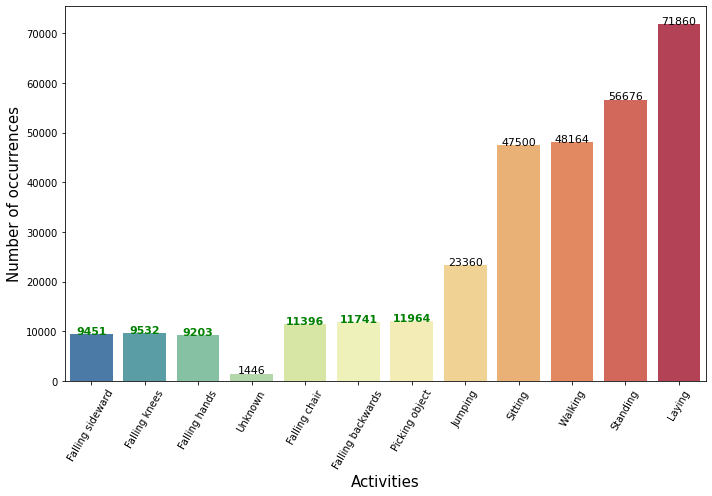

In [ ]:


# class_name = [    'Unknown' ,
#                 'Falling hands' ,
#                  'Falling knees' ,
#                  'Falling backwards',
#                  'Falling sideward' ,
#                 ' Falling chair',
#                 ' Walking',
#                  'Standing' ,
#                  'Sitting' ,
#                  'Picking object' ,
#                  'Jumping' ,
#                  'Laying' ]

# label_name = []
# for i in range(len(y_final)):
#   label_name.append(class_name[int(y_final[i])])
# import seaborn as sns 
# ord = ['Falling sideward', 'Falling knees','Falling hands', 'Unknown',' Falling chair','Falling backwards','Picking object','Jumping','Sitting',
#        ' Walking','Standing','Laying']
# countplt, ax = plt.subplots(figsize = (10,7))
# sns.countplot(x = 'col2', data = df , palette='Spectral_r', order = ord)
# plt.xticks(rotation=60)
# # ax.set_title('Distribution of UP-Fall dataset ',fontsize = 18, fontweight='bold' )
# ax.set_xlabel('Activities', fontsize = 15)
# ax.set_ylabel('Number of occurrences', fontsize = 15)


# # for rect in ax.patches[0:7]:
# #     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
# #              color = 'red', fontweight = 'bold')
    
# # for rect in ax.patches[7:]:
# #     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
# #              )



# for rect in ax.patches[0:3]:
#     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
#              color = 'green', fontweight = 'bold')

# for rect in ax.patches[3:4]:
#     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
#            )

# for rect in ax.patches[4:7]:
#     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
#              color = 'green', fontweight = 'bold')
    
# for rect in ax.patches[7:]:
#     ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.8,rect.get_height(),horizontalalignment='center', fontsize = 11,
#              )


# # plt.show()
# plt.tight_layout()
# plt.savefig('dis1.png', dpi = 600)

In [ ]:
X_train_1_scaled = X_train_1/255.0
X_train_2_scaled = X_train_2/255.0

X_val_1_scaled = X_val_1/255.0
X_val_2_scaled = X_val_2/255.0

X_test_1_scaled = X_test_1/255.0
X_test_2_scaled = X_test_2/255.0

In [ ]:


print(X_train_1_scaled.shape)
print(X_test_1_scaled.shape)
print(X_val_1_scaled.shape)

print(X_train_2_scaled.shape)
print(X_test_2_scaled.shape)
print(X_val_2_scaled.shape)

(209047, 32, 32)
(51623, 32, 32)
(51623, 32, 32)
(209047, 32, 32)
(51623, 32, 32)
(51623, 32, 32)


# IMAGE 1 

In [ ]:
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)

X_train_1 shape :  (209047, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (209047,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (209047, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)


In [ ]:
img1_gating = model_1concat_gating(shape1 = 32,
                                   shape2 = 32, 
                                       all_list_filters = [[32],
                                                           [32],
                                                           [32],
                                                           [32],
                                                           [32]
                                                          ], 
                                       list_num_experts = 5, 
                                       same_seed = False)
img1_gating.summary()


expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 30, 30, 30)   300         ['input_3[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 30, 30, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 30, 30, 32)   320         ['input_3[0][0]']                
                         

best model: 
1614/1614 [==============================] - 12s 7ms/step - loss: 0.0203 - categorical_accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949 - f1_score: 0.9950
[0.020290236920118332, 0.9950022101402283, 0.9950595498085022, 0.9949053525924683, 0.994954526424408]
1614/1614 [==============================] - 11s 7ms/step - loss: 0.0214 - categorical_accuracy: 0.9950 - precision: 0.9950 - recall: 0.9948 - f1_score: 0.9949
[0.021356577053666115, 0.9949634671211243, 0.9950013756752014, 0.9948278665542603, 0.9949277639389038]
Accuracy score :  0.9950022276892083
Precision score :  0.994953168476056
Recall score :  0.9950022276892083
F1 score :  0.9949545493766342
********************
Accuracy score :  0.9949634852681944
Precision score :  0.9949370667577576
Recall score :  0.9949634852681944
F1 score :  0.9949277848699913


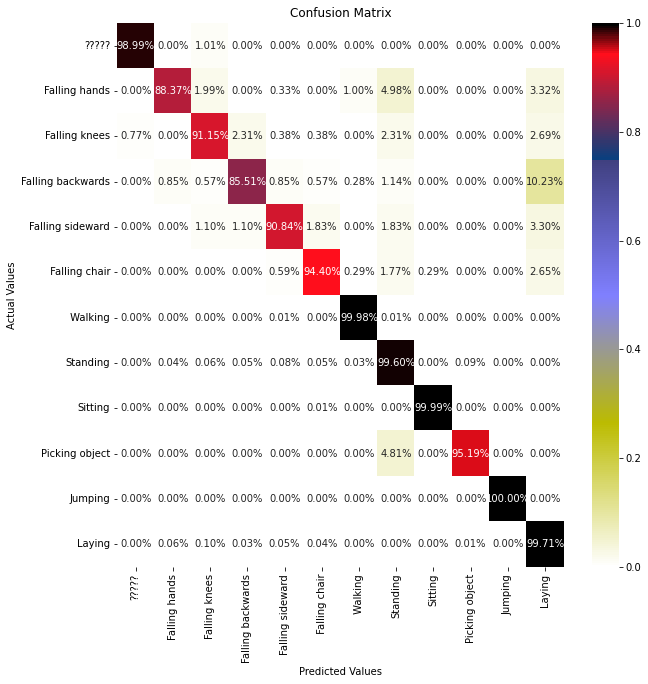

[0.9899, 0.8837, 0.9115, 0.8551, 0.9084, 0.944, 0.9998, 0.996, 0.9999, 0.9519, 1.0, 0.9971]


In [ ]:
# LOAD OUR PRE-TRAINED WEIGHTS

img1_gating.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.9615, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("Saved Model/New_1/gating_img1_3.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

print("best model: ")
img1_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_img1.hdf5")
print(img1_gating.evaluate(X_val_1_scaled , Y_val_1))
print(img1_gating.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(img1_gating.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(img1_gating.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


k = draw_cm(y_test_1,y_test) 
print(k)

In [ ]:
take_f1_Score(y_test_1,y_test)

[99.16, 91.25, 89.1, 89.58, 91.01, 94.12, 99.95, 99.57, 99.99, 95.81, 100.0, 99.61]


In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL AGAIN

# img1_gating.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.9615, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted')                          
#                            ]
#     )

# f1_callback_concat = ModelCheckpoint("Saved Model/New_1/gating_img1_3.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = img1_gating.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


# print("best model: ")
# img1_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_img1.hdf5")
# print(img1_gating.evaluate(X_val_1_scaled , Y_val_1))
# print(img1_gating.evaluate(X_test_1_scaled , Y_test_1))


# y_val = np.argmax(img1_gating.predict(X_val_1_scaled ), axis = 1 )
# display_result(y_val_1, y_val)

# print('*'*20)
# y_test = np.argmax(img1_gating.predict(X_test_1_scaled ), axis = 1 )
# display_result(y_test_1, y_test)



# IMAGE 2

In [ ]:
img2_gating = model_1concat_gating(shape1 = 32,
                                   shape2 = 32, 
                                    all_list_filters = [[32],
                                                           [32,28],
                                                           [32,28,24],
                                                           [32,28,24,24],
                                                           [32,28,24,24,20],
                                                           [32,28,24,24,20,20]
                                                          ], 
                                       list_num_experts = 6, 
                                       same_seed = True)
img2_gating.summary()


expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 30, 30, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 30, 30, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 15, 15, 32)  0           ['conv2d_21[0][0]']              
 )                       

best model: 
1614/1614 [==============================] - 31s 17ms/step - loss: 0.0149 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - f1_score: 0.9962
[0.014890973456203938, 0.9962226152420044, 0.9962419271469116, 0.9962226152420044, 0.9961979389190674]
1614/1614 [==============================] - 19s 12ms/step - loss: 0.0138 - categorical_accuracy: 0.9961 - precision: 0.9962 - recall: 0.9961 - f1_score: 0.9961
[0.013810678385198116, 0.9961063861846924, 0.9961642026901245, 0.9960870146751404, 0.9960920810699463]
Accuracy score :  0.9962226139511458
Precision score :  0.9961952555524237
Recall score :  0.9962226139511458
F1 score :  0.9961979249017071
********************
Accuracy score :  0.9961063866881041
Precision score :  0.9960908754625143
Recall score :  0.9961063866881041
F1 score :  0.996092042972985


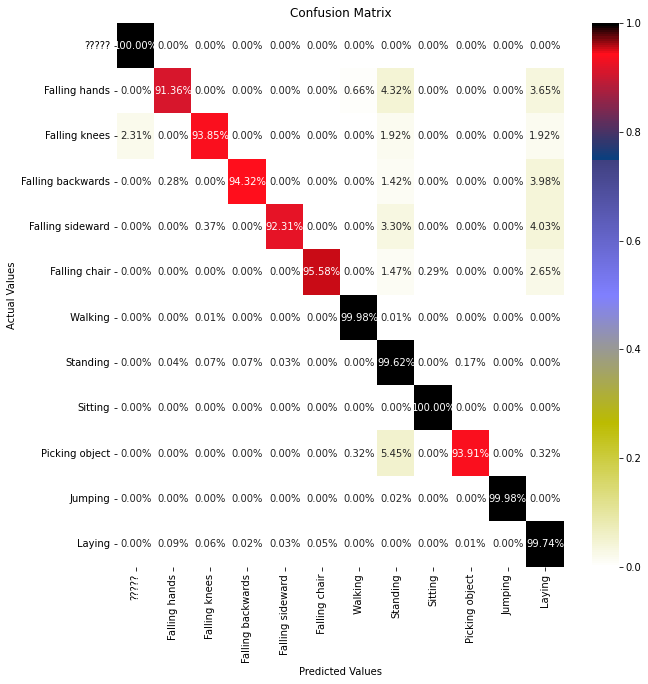

[1.0, 0.9136, 0.9385, 0.9432, 0.9231, 0.9558, 0.9998, 0.9962, 1.0, 0.9391, 0.9998, 0.9974]


In [ ]:
img2_gating.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.9234, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

# f1_callback_concat = ModelCheckpoint("Saved Model/New_1/gating_img2_3.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = img2_gating.fit(x = X_train_2_scaled , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_2_scaled , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )

print("best model: ")
img2_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_img2.hdf5")
print(img2_gating.evaluate(X_val_2_scaled , Y_val_2))
print(img2_gating.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(img2_gating.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(img2_gating.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)


k = draw_cm(y_test_2,y_test) 
print(k)


In [ ]:
take_f1_Score(y_test,y_test_2)

[99.0, 92.44, 93.31, 95.54, 94.56, 96.72, 99.97, 99.56, 99.99, 93.76, 99.99, 99.69]


In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL AGAIN

# img2_gating.compile(
#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.9234, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted')                          
#                            ]
#     )

# f1_callback_concat = ModelCheckpoint("Saved Model/New_1/gating_img2_3.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = img2_gating.fit(x = X_train_2_scaled , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_2_scaled , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )

# print("best model: ")
# img2_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_img2.hdf5")
# print(img2_gating.evaluate(X_val_2_scaled , Y_val_2))
# print(img2_gating.evaluate(X_test_2_scaled , Y_test_2))


# y_val = np.argmax(img2_gating.predict(X_val_2_scaled ), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(img2_gating.predict(X_test_2_scaled ), axis = 1 )
# display_result(y_test_2, y_test)

# IMAGE 1 + IMAGE 2

## Average

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 29s 12ms/step - loss: 0.0121 - categorical_accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - f1_score: 0.9968
[0.012110419571399689, 0.9968231320381165, 0.9968423843383789, 0.9968037605285645, 0.9967941045761108]
1614/1614 [==============================] - 19s 12ms/step - loss: 0.0113 - categorical_accuracy: 0.9967 - precision: 0.9967 - recall: 0.9966 - f1_score: 0.9967
[0.011326966807246208, 0.9966875314712524, 0.9967066049575806, 0.9966100454330444, 0.9966594576835632]
Accuracy score :  0.9968231214768611
Precision score :  0.9967919418017307
Recall score :  0.9968231214768611
F1 score :  0.996794058404917
********************
Accuracy score :  0.9966875230033124
Precision score :  0.9966657198851189
Recall score :  0.9966875230033124
F1 score :  0.9966594053861382


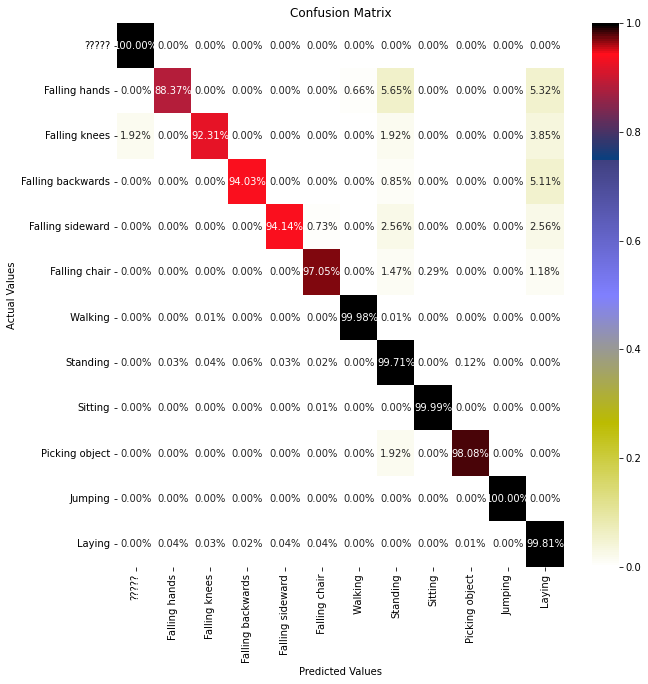

[1.0, 0.8837, 0.9231, 0.9403, 0.9414, 0.9705, 0.9998, 0.9971, 0.9999, 0.9808, 1.0, 0.9981]
[99.17, 92.36, 94.12, 95.53, 95.36, 96.91, 99.98, 99.66, 99.99, 96.68, 100.0, 99.72]


In [ ]:
ss = 'average'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)

# LOAD OUR PRE-TRAINED WEIGHT 


model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])



print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss + '.hdf5'

model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)


dd = draw_cm(y_test_2,y_test)
print(dd)
take_f1_Score(y_test_2,y_test)

In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL AGIAN


# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = ss)
# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss + '.hdf5'

# model_concat_12.load_weights(path)
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)


## MAX 

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 29s 12ms/step - loss: 0.0128 - categorical_accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - f1_score: 0.9966
[0.012764433398842812, 0.9966100454330444, 0.9966293573379517, 0.9966100454330444, 0.9965947866439819]
1614/1614 [==============================] - 19s 12ms/step - loss: 0.0128 - categorical_accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - f1_score: 0.9965
[0.01278041023761034, 0.9964938163757324, 0.9964938163757324, 0.9964938163757324, 0.9964829087257385]
Accuracy score :  0.9966100381612847
Precision score :  0.9965907833551575
Recall score :  0.9966100381612847
F1 score :  0.9965948142687805
********************
Accuracy score :  0.9964938108982431
Precision score :  0.996482563901076
Recall score :  0.9964938108982431
F1 score :  0.9964828789941292


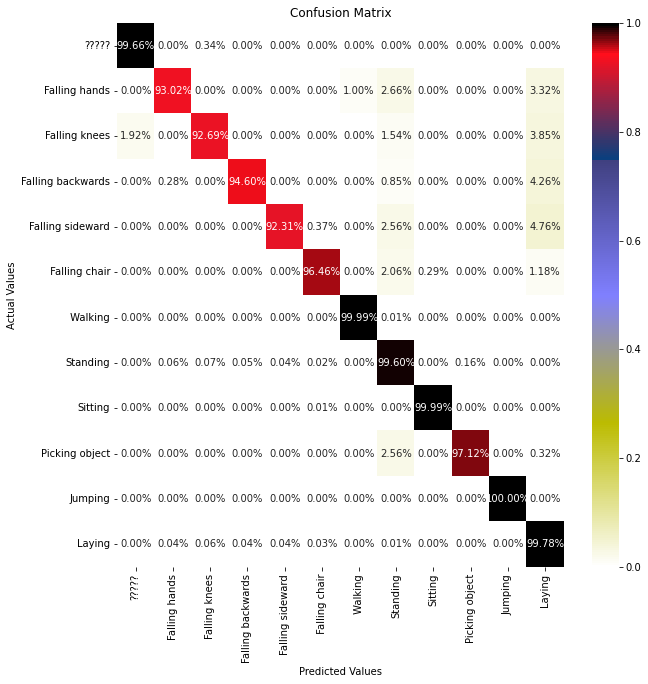

[0.9966, 0.9302, 0.9269, 0.946, 0.9231, 0.9646, 0.9999, 0.996, 0.9999, 0.9712, 1.0, 0.9978]
[99.0, 94.12, 93.05, 95.55, 94.21, 96.89, 99.98, 99.63, 99.99, 95.73, 100.0, 99.7]


In [ ]:
ss = 'max'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)

# LOAD OUR PRE-TRAINED WEIGHT 

model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])



print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss  + '.hdf5'

model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)


dd = draw_cm(y_test_2,y_test)
print(dd)


take_f1_Score(y_test_2,y_test)

In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL AGAIN

# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = ss)

# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss  + '.hdf5'

# model_concat_12.load_weights(path)
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)

## Concat

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 30s 12ms/step - loss: 0.0160 - categorical_accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - f1_score: 0.9966
[0.015956945717334747, 0.9966294169425964, 0.9966294169425964, 0.9966294169425964, 0.9966275691986084]
1614/1614 [==============================] - 20s 12ms/step - loss: 0.0171 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - f1_score: 0.9962
[0.017145700752735138, 0.9962226152420044, 0.9962417483329773, 0.9961838722229004, 0.9962186813354492]
Accuracy score :  0.9966294093717917
Precision score :  0.9966468074705791
Recall score :  0.9966294093717917
F1 score :  0.9966275330337373
********************
Accuracy score :  0.9962226139511458
Precision score :  0.9962299805451887
Recall score :  0.9962226139511458
F1 score :  0.9962186694050931


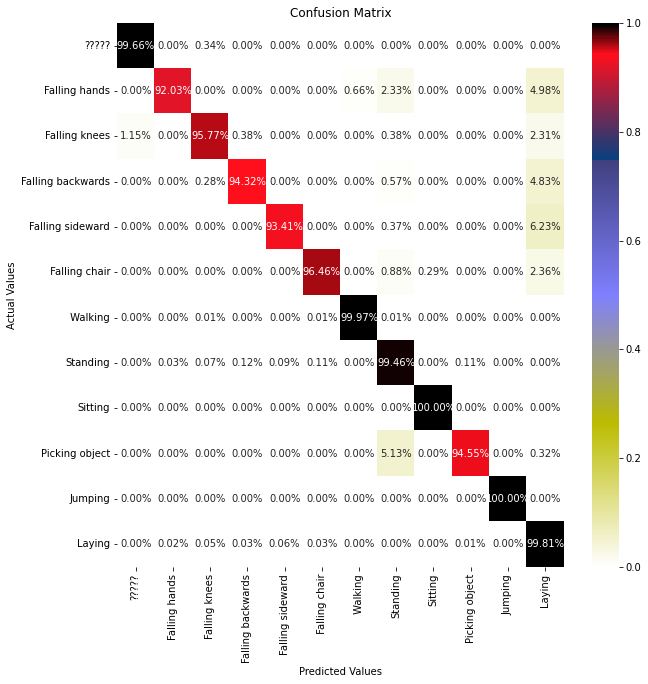

[0.9966, 0.9203, 0.9577, 0.9432, 0.9341, 0.9646, 0.9997, 0.9946, 1.0, 0.9455, 1.0, 0.9981]
[99.33, 94.86, 94.5, 94.45, 93.24, 95.61, 99.97, 99.59, 99.99, 95.01, 100.0, 99.68]


In [ ]:
ss = 'concat'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)
# model_concat_12.summary()


model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss  + '.hdf5'

model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)


dd = draw_cm(y_test_2,y_test)
print(dd)
take_f1_Score(y_test_2,y_test)

In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL AGIAN 

# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = ss)

# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.98, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/aug_" + ss  + '.hdf5'

# model_concat_12.load_weights(path)
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)